## 1. Loading the data and artifacts

In [1]:
label2id = {
    'ISSUE': 0,
    'NONE': 1,
    'STA': 2,
    'ANALYSIS': 3,
    'PRE_RELIED': 4,
    'RATIO': 5,
    'RPC': 6,
    'PRE_NOT_RELIED': 7,
    'ARG_PETITIONER': 8,
    'PREAMBLE': 9,
    'RLC': 10,
    'ARG_RESPONDENT': 11,
    'FAC': 12
}

id2label = {v: k for k, v in label2id.items()}

In [2]:
import pickle as pkl
from typing import Dict, List
from sklearn.model_selection import train_test_split

from datautils import RRDataModule, RRBatcher

DPATH = "../data/dev.json"
TPATH = "sentence-transformers/all-MiniLM-L6-v2"

batcher = RRBatcher(TPATH)
datamodule = RRDataModule(DPATH, batcher, label2id)

c:\ProgramData\Miniconda3\envs\expt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Generate the Vectors

### 2.1 Get the embeddings

In [ ]:
import torch
from pytorch_lightning import Trainer, seed_everything
from modelling import CoherenceAwareSentenceEmbedder


CKPT = "../models/coherence-aware/all-MiniLM-L6-v2/imp=0.2-epoch=10-val_sem_loss=0.93.ckpt"
seed_everything(42, workers=True)

model = CoherenceAwareSentenceEmbedder.load_from_checkpoint(CKPT)
trainer = Trainer(deterministic=True, accelerator='gpu')
rsents_embeddings = trainer.predict(model, dataloaders=datamodule)

# Collate the batch-wise results
rsents_embeddings = torch.vstack(rsents_embeddings).cpu()

## 3. Visualize them using t-SNE and PCA

In [12]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


# Masked/raw sentences in 2-D embedding space
rsents_locs = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50).fit_transform(rsents_embeddings)

pca_rsents_locs = PCA().fit_transform(rsents_embeddings)

### 3.1 Plotting

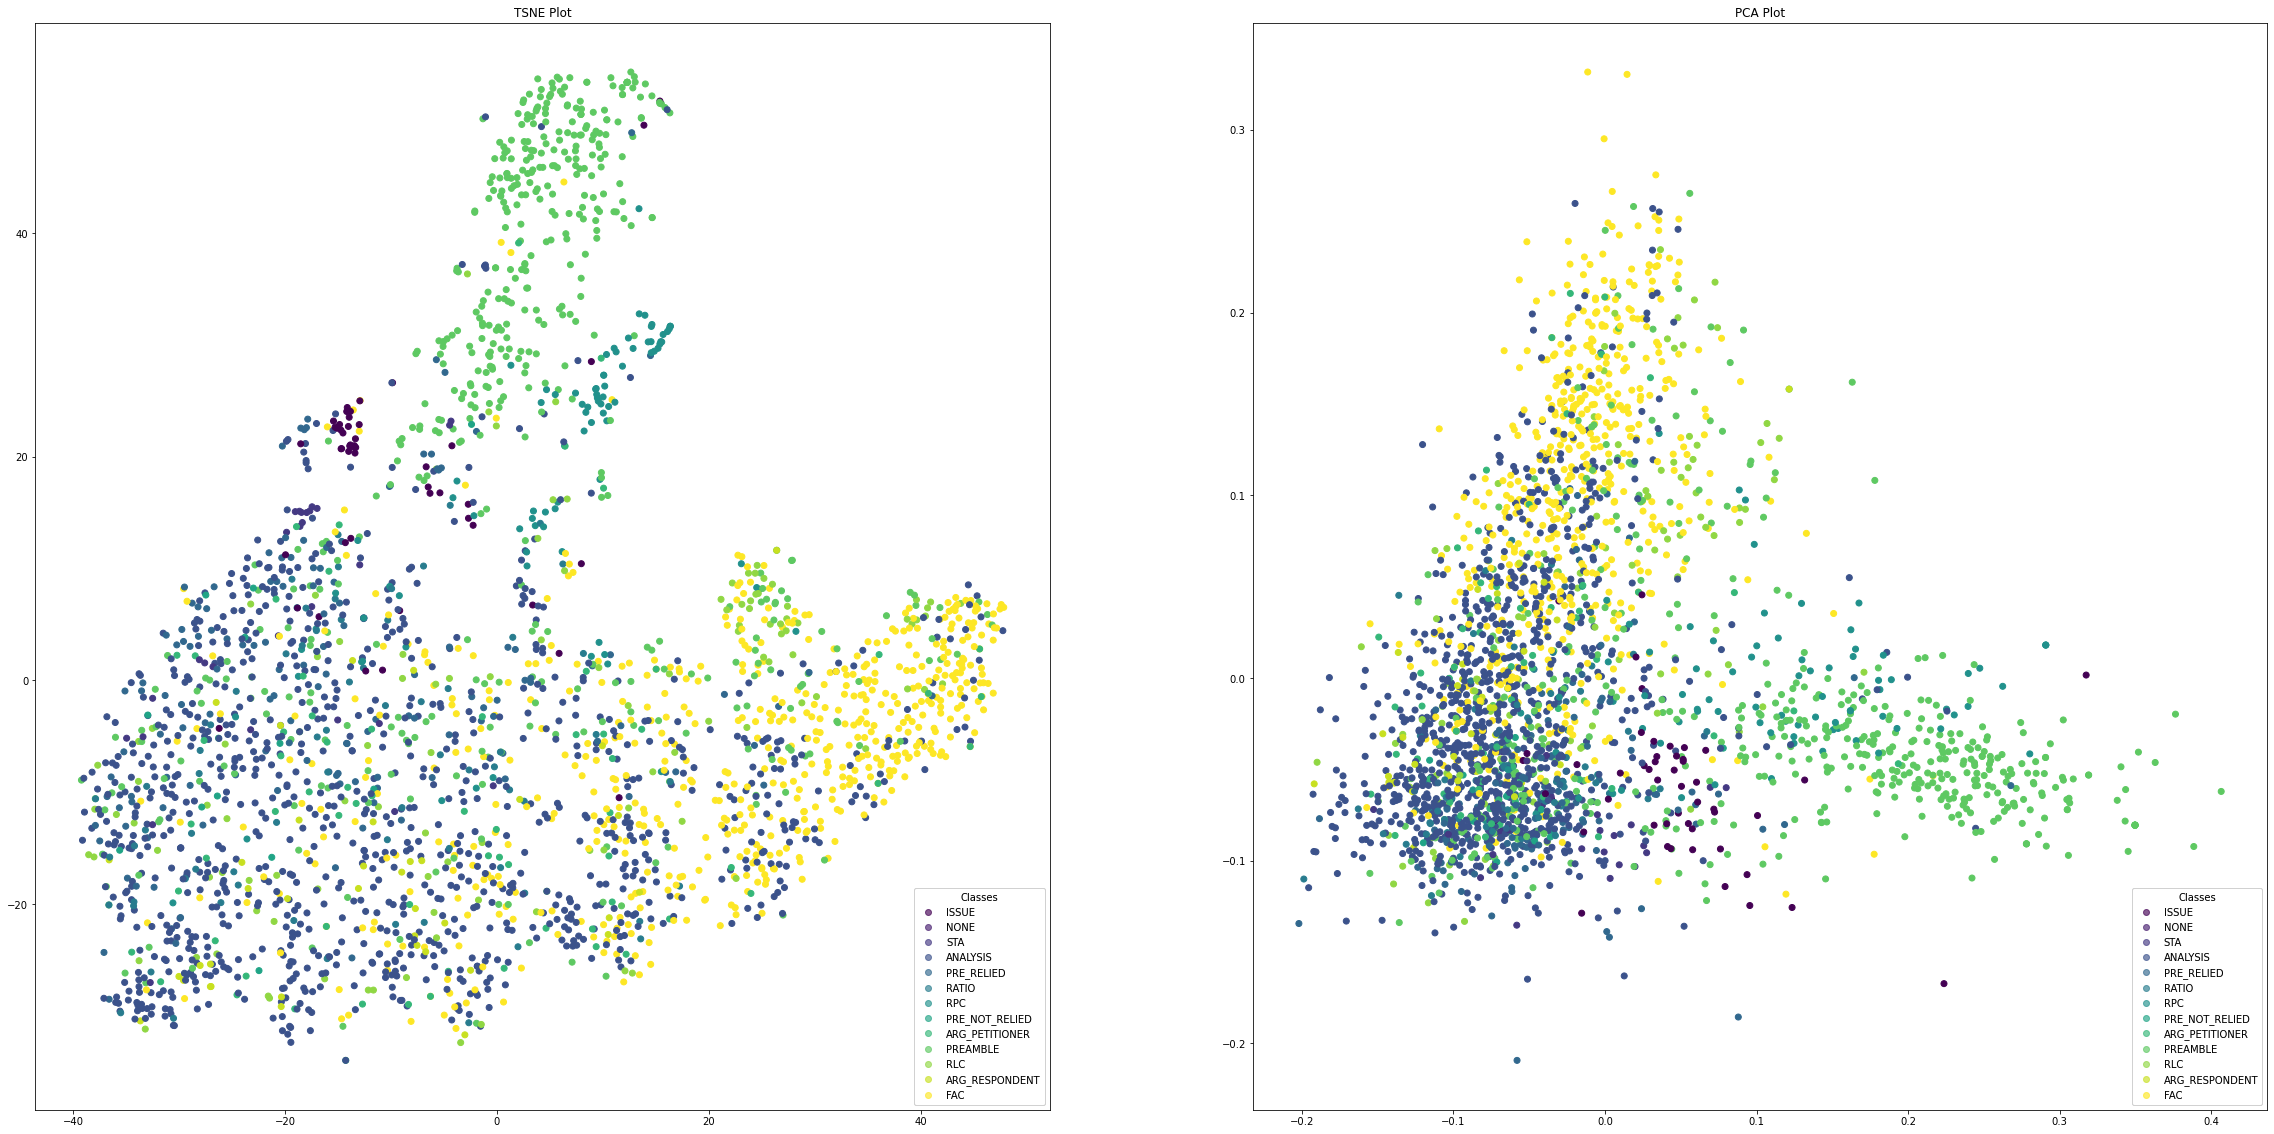

In [13]:
import matplotlib.pyplot as plt


# The Rhetorical Roles (classes)
labels = list(id2label.values())
rh_roles = np.array([obj[1][0] for obj in datamodule.pred_dataset])

# All the indices with `None` class
keep_idx = (rh_roles != label2id['NONE']).nonzero()[0]
# Ignore all the none classes
rh_roles = np.take(rh_roles, keep_idx)
rsents_locs = np.take(rsents_locs, keep_idx, axis=0)
pca_rsents_locs = np.take(pca_rsents_locs, keep_idx, axis=0)

fig, axs = plt.subplots(1, 2, figsize=[40, 20])

scatter1 = axs[0].scatter(rsents_locs[:, 0], rsents_locs[:, 1], c=rh_roles)
axs[0].set_title('TSNE Plot')
handles, _ = scatter1.legend_elements(prop="colors", alpha=0.6)
legend1 = axs[0].legend(handles, labels, loc="lower right", title="Classes")
axs[0].add_artist(legend1)


scatter2 = axs[1].scatter(pca_rsents_locs[:, 0], pca_rsents_locs[:, 1], c=rh_roles)
axs[1].set_title('PCA Plot')
handles, _ = scatter2.legend_elements(prop="colors", alpha=0.6)
legend1 = axs[1].legend(handles, labels, loc="lower right", title="Classes")
axs[1].add_artist(legend1)

plt.show()